In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import datetime

import seaborn as sns

Ultimate goal: predict the catch per angler for the next week per location

# Explore Data Analysis

In [2]:
def read_in_fish_data(fish_data_dir = 'data/'):
    
    fish_data_files = os.listdir(fish_data_dir)
    l = list()
    for file in fish_data_files:
        l.append(pd.read_csv(fish_data_dir + file))
    return(pd.concat(l))

In [49]:
# read in data
pdf_fish = read_in_fish_data(fish_data_dir='/Users/halasadi/Documents/salmon-forecasting/data/')

In [51]:
# add in a pseudo count to avoid divide by zero errors
pdf_fish['Chinook (per angler)'] = (pdf_fish['Chinook'] + 0.1) / (pdf_fish['Anglers'] + 1)

In [52]:
# format date

pdf_fish['sample_date_formatted'] = pdf_fish.apply(lambda x: datetime.strptime(x['Sample date'], '%b %d, %Y'), axis=1)
pdf_fish['month'] = pdf_fish['sample_date_formatted'].dt.month
pdf_fish['year']  = pdf_fish['sample_date_formatted'].dt.year
pdf_fish['day']   = pdf_fish['sample_date_formatted'].dt.day
pdf_fish['week']  = pdf_fish['sample_date_formatted'].dt.isocalendar().week

In [53]:
# we only care about the summer months for salmon migration
summ_pdf = pdf_fish.query('month >= 7 & month <= 10').reset_index(drop=True).groupby(['week', 'Catch area']).agg(
    mean_chinook_per_angler = ("Chinook (per angler)", "mean"),
    num_anglers = ("Anglers", "sum")
).reset_index()

In [54]:
# keep only the areas that are sampled regularly
summ_pdf = summ_pdf[summ_pdf['Catch area'].isin(['Area 10, Seattle-Bremerton area', 'Area 11, Tacoma-Vashon Island',
                             'Area 13, South Puget Sound', 'Area 4, Eastern portion', 'Area 5, Sekiu and Pillar Point',
                             'Area 9, Admiralty Inlet', 'Area 12, Hood Canal'])]

# remove weeks with little data
# not sure if this does anything but makes me feel better
summ_pdf = summ_pdf[summ_pdf['num_anglers'] > 100]

In [55]:
# remove everything after the number in the catch area so to make the legend easier to read
summ_pdf['Catch area'] = summ_pdf['Catch area'].str.split(',').str[0]

# turn week into a int type so that it can be plotted
summ_pdf['week'] = summ_pdf['week'].astype(int)

In [72]:
def get_month_and_day_from_week(week_number, year = 2023):
    # Create a date object for the first day of the given year
    start_of_year = datetime.date(year, 1, 1)

    # Calculate the number of days to the first day of the first week
    days_to_first_week = (week_number - 1) * 7

    # Calculate the date of the first day of the given week
    first_day_of_week = start_of_year + datetime.timedelta(days=days_to_first_week)

    # Calculate the month and day of the first day of the given week
    month = first_day_of_week.strftime("%B")
    day = first_day_of_week.day

    return str(month), str(day)


In [73]:
# convert week number to month and day
summ_pdf['month'], summ_pdf['day'] = zip(*summ_pdf.apply(lambda x: get_month_and_day_from_week(x['week']), axis=1))

Text(0.5, 0, 'Week')

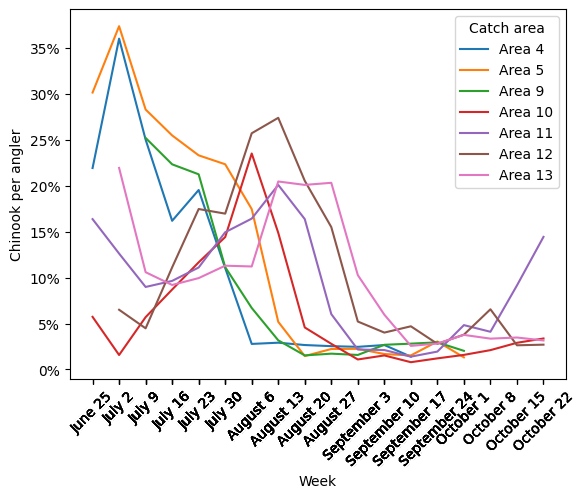

In [75]:
# plot by weeknumber and show the month and day and rotate the x axis labels
sns.lineplot(x='week', y='mean_chinook_per_angler', data=summ_pdf, hue='Catch area',
             hue_order=["Area 4", "Area 5", "Area 9", "Area 10", "Area 11", "Area 12", "Area 13"])
plt.xticks(summ_pdf['week'], summ_pdf['month'] + ' ' + summ_pdf['day'])
plt.xticks(rotation=45)
# convert ylabels to percentages
plt.gca().yaxis.set_major_formatter(lambda y, _: '{:.0%}'.format(y))
# relabel y axis
plt.ylabel('Chinook per angler')
plt.xlabel('Week')

From this plot we can take away a few things


#1 There is temporal structure in the data reflecting the migration of salmon from the ocean to the inner streches of the rivers in Puget Sound. For instance, you can see that Area 4,5 (orange + blue) reach a peak first at week 28, then the salmon move to Area 9 (green), then Area 10 (green) and move to 11, 12, 13. 

#2 There are trends that do not follow the physical migration, Area 11-13 have relatively high catch rates in the begining of the summer and the end, why is that? Well, those areas legally open first and there is a large background catch of resident king salmon (called "blackmouths") that do not migrate in from the ocean. Put another way, the data here is "censored", such that fishing is only allowed in certain times which depends on the area. 

## Collecting the dates when fishing is not allowed

2011: https://wdfw.wa.gov/publications/01438
2012: 